# Example use of local_pcangsd

Here, we use some maize low-coverage data from the paper [Calfee et al. 2021](https://doi.org/10.1371/journal.pgen.1009810) on chromosome 4 where an inversion has been identified.

The starting file format is a genotype likelihood file (beagle) that can be produced for example by `ANGSD`.

After the conversion, we subset chr4 between 150 and 200 Mb to reduce the dataset.

In [1]:
import os
import local_pcangsd as lp
import lostruct
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import pandas as pd
import numpy as np

In [2]:
input = "data/hilo/analyses/hilo_chr4.beagle.gz" # input genotype likelihood file
store = "data/hilo/analyses/hilo_chr4.zarr" # where to store the transformed file

Now we produce an on-disk format of the genotype likelihoods.

`local_pcangsd` functions work with an `xarray.Dataset` to avoid loading all genotype likelihoods into memory.

The Dataset in stored as a zarr file.

Run the following only once.

In [3]:
if not os.path.exists(store):
    lp.beagle_to_zarr(input, store, chunksize=100000)

In [4]:
ds = lp.load_dataset(store, chunks=100000) # open the Dataset
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
	ds = ds.sel({'variants': (ds.variant_position > 150e6) & (ds.variant_position < 200e6)})
ds

<xarray.Dataset>
Dimensions:              (variants: 1280891, alleles: 2, samples: 453, genotypes: 3)
Dimensions without coordinates: variants, alleles, samples, genotypes
Data variables:
    allele               (variants, alleles) int8 dask.array<chunksize=(95225, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(95225, 453, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(453,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(95225,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(95225,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(95225,), meta=np.ndarray>
Attributes:
    contigs:  ['4']

The dataset is similar in structure to the sgkit format.

We now create windows variables, using sgkit functions internally.

In [5]:
ds = lp.window(ds, type='position', size=20000)
ds

<xarray.Dataset>
Dimensions:              (windows: 2251, variants: 1280891, alleles: 2, samples: 453, genotypes: 3)
Dimensions without coordinates: windows, variants, alleles, samples, genotypes
Data variables:
    window_contig        (windows) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    window_start         (windows) int64 0 1185 1451 ... 1278317 1279580 1280337
    window_stop          (windows) int64 1185 1451 2030 ... 1280337 1280891
    allele               (variants, alleles) int8 dask.array<chunksize=(95225, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(95225, 453, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(453,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(95225,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(95225,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(95225,), meta=np.ndarray>
Attributes:
    contigs:  ['4']

We compute PCAngsd on each window. This step is parallelized by default through `dask`.
Each PCAngsd process still uses a relatively large amount of memory, so be careful to scale accordingly.

In [7]:
%%time
pca_zarr_store = lp.pca_window(
	ds,
	zarr_store='data/hilo/hilo_local_pcangsd.zarr', # where to store the result
	tmp_folder='./tmp_local_pcangsd', # need a tmp folder, /tmp is default
	k=5, # number of PCs to retain
)

/data/home/alexis/local_pcangsd/src/local_pcangsd/local_pcangsd.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(np.float32)
/data/home/alexis/local_pcangsd/src/local_pcangsd/local_pcangsd.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors = vectors.astype(np.float32)
/opt/miniconda3/envs/local_pcangsd/lib/python3.9/site-packages/xarray/conventions.py:201: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


CPU times: user 8h 47min 3s, sys: 8h 45min 51s, total: 17h 32min 54s
Wall time: 1h 19min 10s


The produced PCA result is also stored as a `xarray.Dataset` for easy access.
It can be loaded using the `xarray` module.

In [5]:
ds_pca = lp.load_dataset('data/hilo/hilo_local_pcangsd.zarr')
ds_pca

<xarray.Dataset>
Dimensions:         (windows: 2251, samples_0: 453, samples_1: 453, samples: 453, PCs: 5)
Dimensions without coordinates: windows, samples_0, samples_1, samples, PCs
Data variables:
    C               (windows, samples_0, samples_1) float32 dask.array<chunksize=(2251, 453, 453), meta=np.ndarray>
    sample_id       (windows, samples) object dask.array<chunksize=(2251, 453), meta=np.ndarray>
    total_variance  (windows) float32 dask.array<chunksize=(2251,), meta=np.ndarray>
    vals            (windows, PCs) float32 dask.array<chunksize=(2251, 5), meta=np.ndarray>
    vectors         (windows, PCs, samples) float32 dask.array<chunksize=(2251, 5, 453), meta=np.ndarray>
    window_contig   (windows) int64 dask.array<chunksize=(2251,), meta=np.ndarray>
    window_start    (windows) int64 dask.array<chunksize=(2251,), meta=np.ndarray>
    window_stop     (windows) int64 dask.array<chunksize=(2251,), meta=np.ndarray>
Attributes:
    contigs:  ['4']

Now we transform the result into a format understandable by the `lostruct` python module, i.e. a `numpy.array`.
First dimension of the lostruct array is for windows.
Each element contains the covariance matrix, the total variance, the eigen values and the eigen vectors (second dimension of 4).

In [7]:
results = lp.to_lostruct(ds_pca)

In [13]:
print(f"Results on {results.shape[0]} windows")

Results on 2251 windows


With the `lostruct` module, we compute the distance between window PCAs.
Then we perform MDS on those distances.

In [14]:
pc_dists = lostruct.get_pc_dists(results)

In [15]:
mds = pcoa(pc_dists)

Text(0, 0.5, 'MDS 1')

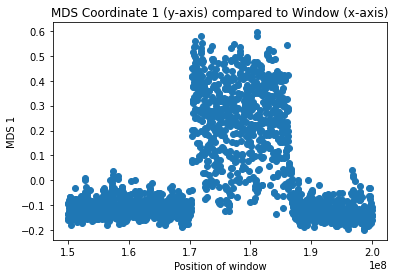

In [113]:
pos_start = ds.variant_position.values[ds.window_start]
pos_stop = ds.variant_position.values[ds.window_stop.values - 1]
window_center = pos_start + (pos_stop - pos_start)/2

plt.figure()
plt.scatter(x=window_center, y=mds.samples["PC1"])
plt.title("MDS Coordinate 1 (y-axis) compared to Window (x-axis)")
plt.xlabel("Position of window (bp)")
plt.ylabel("MDS 1")

Text(0, 0.5, 'MDS 2')

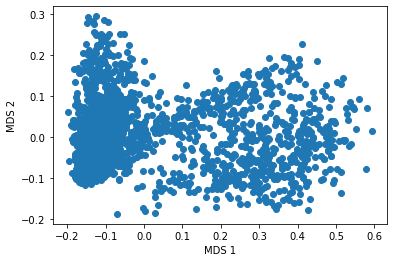

In [18]:
plt.figure()
plt.scatter(x=mds.samples["PC1"], y=mds.samples["PC2"])
plt.xlabel("MDS 1")
plt.ylabel("MDS 2")

In [41]:
mds_12 = mds.samples.loc[:, ["PC1", "PC2"]].copy()
xy = mds_12.to_numpy()
corners = lp.corners(xy, prop=0.05, k=3)
print(corners[:10])

[[  0 921  28]
 [  5 925 196]
 [  6 937 198]
 [  9 942 236]
 [ 65 943 297]
 [ 66 944 397]
 [ 69 950 400]
 [ 70 951 425]
 [ 71 952 446]
 [ 72 954 533]]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

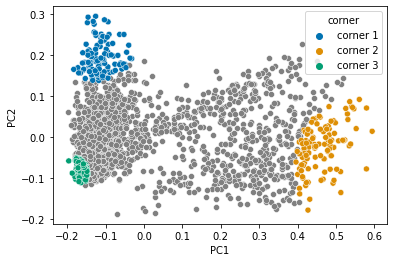

In [116]:
mds_12['corner'] = 'other'
mds_12['window'] = range(pc_dists.shape[0])
mds_12['window_center'] = window_center
for i in range(3):
	mds_12.iloc[corners[:,i], 2] = f'corner {i+1}'

sns.scatterplot(
	data=mds_12[mds_12.corner=='other'], x="PC1", y="PC2", color='gray',
)
sns.scatterplot(
	data=mds_12[mds_12.corner!='other'], x="PC1", y="PC2", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)

Text(0.5, 0, 'Position of window (bp)')

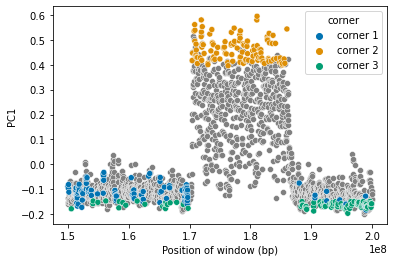

In [117]:
sns.scatterplot(
	data=mds_12[mds_12.corner=='other'],
	x='window_center', y='PC1', color='gray',
)
sns.scatterplot(
	data=mds_12[mds_12.corner!='other'],
	x="window_center", y="PC1", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)
plt.xlabel("Position of window (bp)")

Text(0.5, 0, 'Position of window (bp)')

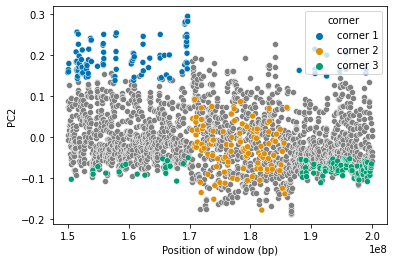

In [118]:
sns.scatterplot(
	data=mds_12[mds_12.corner=='other'],
	x='window_center', y='PC2', color='gray',
)
sns.scatterplot(
	data=mds_12[mds_12.corner!='other'],
	x="window_center", y="PC2", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)
plt.xlabel("Position of window (bp)")

Let's compute the PCA on the combined windows corresponding to the inversion.
All variants from the corner 2 identified windows (orange above) are merged together to compute a common PCA.

In [73]:
corner2_pca = lp.pcangsd_merged_windows(ds, corners[:,1], k=5)

In [90]:
meta = pd.read_csv('data/hilo/other_files/HILO_MAIZE55_PARV50_meta.tsv', sep='\t')
ids = pd.read_csv('data/hilo/other_files/HILO_MAIZE55_PARV50_ids.list', names=['ID'])
meta = meta.set_index(meta.ID).reindex(ids.ID)

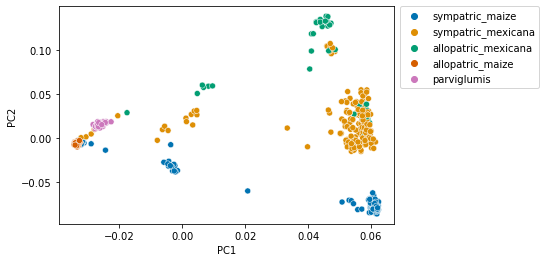

In [91]:
sns.scatterplot(
	x=corner2_pca[3][0], y=corner2_pca[3][1],
	hue=meta['group'],
	palette="colorblind",
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)